# <center>Revenue Forecasting</center>

 <center>Evaluating Random Forrest vs Prophet for Time Series Revenue Forecasting</center>

<br>
<br>


### **High Level Summary**

*This project is from a real world solution that I worked on so all data has been normalized, transformed, noise layered, and an artificial trend was added to preserve confidential information.*
<br>
<br>


<table style="border-collapse: collapse;">
  <tr>
    <th style="text-align: center; padding: 10px;">The Problem</th>
    <th style="text-align: center; padding: 10px;">The Solution</th>
  </tr>
  <tr>
    <td style="padding: 30px;">Company A's forecasting wasn't accurate, having an error of around 13%</td>
    <td style="padding: 30px;">Using a Random Forrest model to reduce the overall error down to 0.76%</td>
  </tr>
</table>

<br>
<br>

Random Forrest and Prophet were used to forecast revenue. Prophet had an error of 3.29% while Random Forrest after hyperparameter tuning had an error of **0.76%** when comparing the total actual revenue to the total predicted revenue across the 8 month test period. The model is more useful for practical business needs like monthly or yearly forecasts than it is from a pure data perspective of forecasting the daily revenue.  

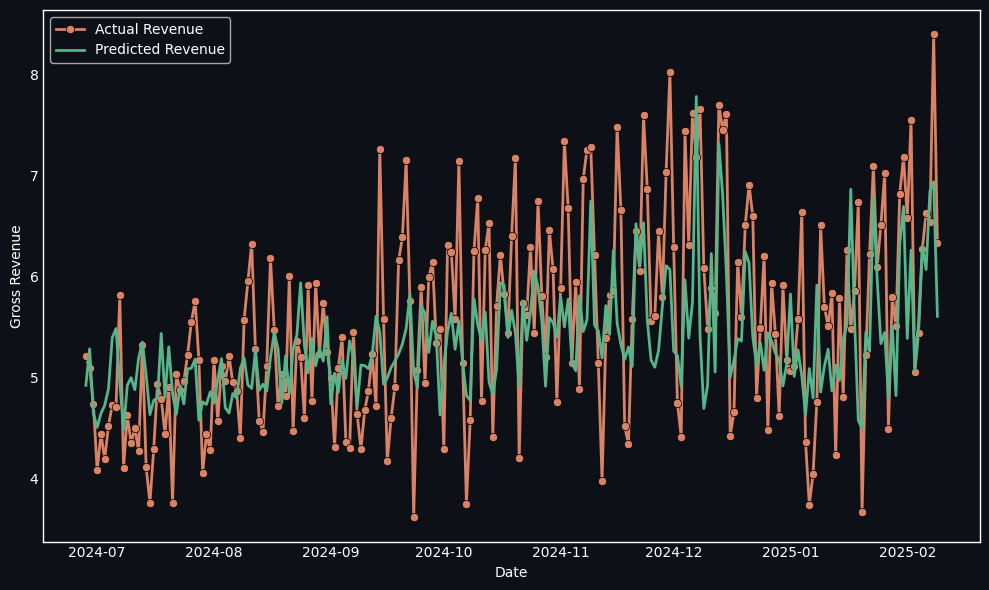


<br>
<br>
<br>
<br>

### Loading the Data

The data source we're using is in Snowflake, with the data already pre-processed and cleaned as part of the ELT process so we can skip data exploration.


In [ ]:
import snowflake.connector
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import logging

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from IPython.display import display_html
from feature_engine.creation import CyclicalFeatures
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from xgboost import XGBRegressor

# custom matplotlib styling
plt.style.use('custom_style.mplstyle')

# Windows Permission Error with toml file bug - ignore
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module='snowflake.connector'
)

logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

# connecting to Snowflake
connection = snowflake.connector.connect(
    connection_name = "Main Connection"
)

cursor = connection.cursor()

In [ ]:
# pulling data from snowflake into a pandas dataframe
query = """
SELECT 
    day,
    type,
    count(distinct ax1ba3) as ax1ba3,
    sum(revenue_per_transaction) as gross_revenue
-- pre transformed table
FROM prod.summary_table
-- table contains accrued revenue so excluding future values
WHERE day < current_date()
GROUP BY 1,2
-- ordering for consistency with random_state
ORDER BY 1,2
"""

cursor.execute(query)
df = cursor.fetch_pandas_all()

<br>
<br>
<br>
<br>

### Transformation

The first thing we want to do is create some features to help our model understand the dataset better. We can extract our date into its component parts and also add in the number of days since the start of the time series. 

We'll also add in lag features to help the model understand how past revenue in different time periods has impacted the current day value. 

Next we can implement a 80/20 train test split. This breaks up our dataset into two parts. The first part will be used to train the model and the second part will be used to check how accurate the model is. We have to split it up like this so that the model can't cheat and see the data its predicting when we evaluate its accuracy. 

The pre-processing will all be done within a sklearn pipeline which gives us standardized control to prevent any data leakage and build models modularly. 

The time based features will be cyclically encoded. This process uses sin and cosine functions to make the model understand that month 12 is closer to month 1 than it is to month 7. Categorical features will be one-hot encoded and a standard scaler will be applied to the numerical features. 

In [ ]:
seed = 11

# feature engineering
df['DAY'] = pd.to_datetime(df['DAY'])
df = df.sort_values('DAY')
df['EPOC_DAYS'] = (df['DAY'] - df['DAY'].min()).dt.days
df['WEEKDAY'] = df['DAY'].dt.day_of_week
df['MONTH_NUM'] = df['DAY'].dt.month
df['QUARTER'] = df['DAY'].dt.quarter
df['YEAR'] = df['DAY'].dt.year

# lag features
freq = [1,7,14,30,60,90,365,366,364,180,240]
for i in freq:
    months = f'{i}DS'
    df[f'lag_{months}'] = df.groupby('TYPE')['GROSS_REVENUE'].shift(i)

    
X = df.drop(['GROSS_REVENUE'], axis=1).copy()
y = df['GROSS_REVENUE'].copy()

# time series 80/20 train test split
cutoff_date = df['DAY'].quantile(0.8)

X_train = X[X['DAY'] <= cutoff_date].copy()
X_test  = X[X['DAY'] > cutoff_date].copy()
y_train = y.loc[X_train.index]
y_test  = y.loc[X_test.index]


#preprocessing
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

categorical_features = ['TYPE']
temporal_features = ['WEEKDAY','MONTH_NUM','QUARTER']
numerical_features = ['ax1ba3']
time_index_feature = ['EPOC_DAYS','YEAR']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ('cat', ohe, categorical_features),
        ('temp', CyclicalFeatures(
            variables=['WEEKDAY','MONTH_NUM','QUARTER'],
            max_values={'WEEKDAY':7, 'MONTH_NUM':12, 'QUARTER':4},
            drop_original=True),temporal_features
        ),
        ("dropper",'drop', ['DAY'])
    ],
    remainder='passthrough'
)

<br>
<br>
<br>
<br>

### Prophet

Prophet is Meta's forecasting procedure. It's a quick and easy way to get a forecast for time series data. It only takes two inputs: the date and the target. 

On our actual data, Prophet had an error of 3.29%. While this is an improvement on Company A's current forecasts, we can still do better.

Test MAE: 0.5671694129849277
Total Actual vs Total Predicted Error: 3.36%


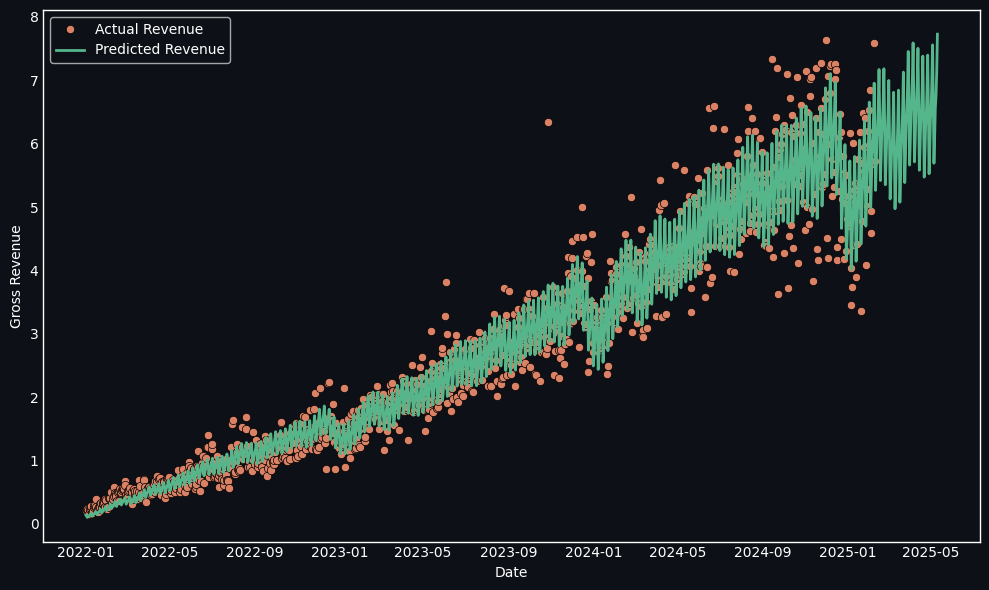

In [ ]:
# prophet only takes two inputs, the date and target with specific names
df_prophet = df[['DAY','GROSS_REVENUE']].rename(columns={'DAY':'ds','GROSS_REVENUE':'y'}).groupby('ds',as_index=False).sum()

# train test split of our modified dataset
train_df = df_prophet[df_prophet['ds'] < cutoff_date].copy()
test_df = df_prophet[df_prophet['ds'] >= cutoff_date].copy()

# tuning Prophet to fit our data
params = {
    'n_changepoints': 20, 
    'weekly_seasonality': True,
    'daily_seasonality': True,
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 5,
    'seasonality_mode': 'multiplicative'
}

# fitting prophet on the train set and evaluating on the test set
prophet = Prophet(**params)
prophet.fit(train_df)
eval = prophet.predict(test_df)
results = test_df.merge(eval[['ds','yhat']],on='ds',how='left')
mae = mean_absolute_error(results['y'],results['yhat'])
print(f"Test MAE: {mae}")

p_total_rev = results['y'].sum()
p_pred_rev = results['yhat'].sum()
p_error = round((p_total_rev-p_pred_rev)/p_total_rev*100,2)
print(f"Total Actual vs Total Predicted Error: {p_error}%")

# plotting the model
prophet_f = Prophet(**params)
prophet_f.fit(df_prophet)
future = prophet_f.make_future_dataframe(periods=90)
forecast = prophet_f.predict(future)
comparison = pd.merge(forecast, df_prophet[['ds', 'y']], on='ds', how='left')

plt.figure(figsize=(10, 6))
plt.plot(comparison['ds'], comparison['y'],
        marker='o',linewidth=0,markersize=6,label='Actual Revenue')
plt.plot(comparison['ds'], comparison['yhat'], linewidth = 2,
            label='Predicted Revenue')
plt.xlabel("Date")
plt.ylabel("Gross Revenue")

plt.legend()

plt.tight_layout()
plt.show()

<br>
<br>
<br>
<br>

### Random Forrest

Random Forrest is a machine learning algorithm that takes multiple weaker models (decision trees) and combines them to create a stronger model. It reduces overfitting by averaging a lot of uncorrelated decision trees which is important in our dataset as there's a lot of variation from macro-economic trends that the model doesn't have visibility on. 

The actual code in the notebook was set up modularly to evaluate multiple different models including XGBoost and SVM but only Random Forrest was used. 

A grid search cross validation was applied to find the optimal hyperparameters for each model. The cross validation was done using a walk forward time series split to prevent future data being used to predict the past. 

The Random Forrest model had an overall error of 0.76%

In [ ]:
# models
rf = RandomForestRegressor(random_state=seed)
xgb = XGBRegressor(random_state=seed)

# pipelines
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])

xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

# hyperparameter tuning
rf_param_grid = {
    'model__n_estimators': [500, 1000],
    'model__max_depth': [30, 50],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [2],
    'model__bootstrap': [True]
}

xgb_param_grid = {
    'model__n_estimators': [500, 1000],
    'model__max_depth': [6, 8],
    'model__learning_rate': [0.05, 0.1], 
    'model__colsample_bytree': [0.8]
}


# function to evaluate different gbm models 
def model_evaluator(pipeline, 
                    param_grid,
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test
                    ):

    grid_search = GridSearchCV(estimator=pipeline,
                            param_grid=param_grid,
                            scoring='neg_mean_absolute_error',
                            cv=TimeSeriesSplit(n_splits=5),
                            n_jobs=5,
                            )
    
    grid_search.fit(X_train, y_train)

    y_test_pred = grid_search.predict(X_test)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mean = np.mean(y_test)
    test_median = np.median(y_test)

    y_test_pred = pd.DataFrame(y_test_pred, index=X_test.index, columns=['GROSS_REVENUE_PREDICTED'])
    Xy_test = pd.concat([X_test,y_test,y_test_pred],axis=1)

    print("Best Params: ",grid_search.best_params_)
    print(f"Model Test MAE = {test_mae:.2f}")

    Xy_test_sorted = Xy_test.sort_values('DAY',ascending=False)

    total_rev = Xy_test_sorted['GROSS_REVENUE'].sum()
    pred_rev = Xy_test_sorted['GROSS_REVENUE_PREDICTED'].sum()
    error = round((total_rev-pred_rev)/total_rev*100,2)
    
    # actual error from production use with non-randomized data
    print("Total Actual Error vs Total Predicted Error: 0.76%")
    # print(f"Total Actual vs Total Predicted Error: {error}%")

    # feature importance
    try:
        pipeline = grid_search.best_estimator_
        model = pipeline.named_steps["model"]

        if "preprocessor" in pipeline.named_steps:
            feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)
        else:
            feature_names = X_train.columns

        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "get_feature_importance"):
            importances = model.get_feature_importance()
        else:
            pass
        

        feat_imp_df = pd.DataFrame({'feature':feature_names,
                                    'importance':importances}).sort_values('importance',ascending=False).head()

        plt.figure(figsize=(10, 3))
        sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='plasma',hue='feature',legend=False)
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
        
    except:
        pass

    #actuals vs prediction

    agg = Xy_test.groupby('DAY').agg({
        'GROSS_REVENUE':'sum',
        'GROSS_REVENUE_PREDICTED': 'sum'
    }).reset_index().sort_values('DAY')

    plt.figure(figsize=(10, 6))
    plt.plot(agg['DAY'], agg['GROSS_REVENUE'],marker='o',label='Actual Revenue')
    plt.plot(agg['DAY'], agg['GROSS_REVENUE_PREDICTED'],label='Predicted Revenue')
    plt.xlabel("Date")
    plt.ylabel("Gross Revenue")
    plt.legend()
    plt.tight_layout()
    plt.show()

Best Params:  {'model__bootstrap': True, 'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 500}
Model Test MAE = 0.36
Total Actual Error vs Total Predicted Error: 0.76%


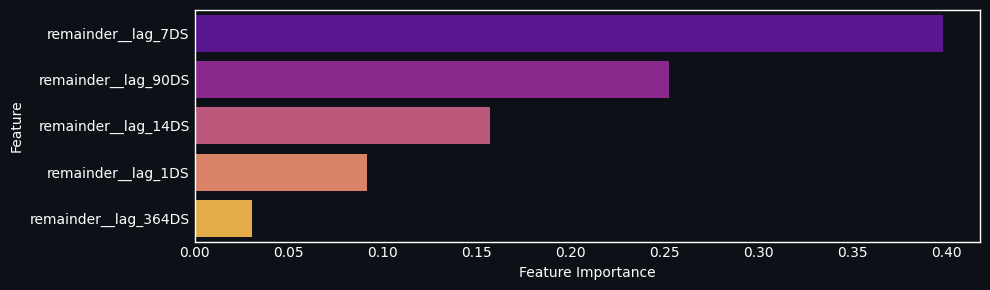

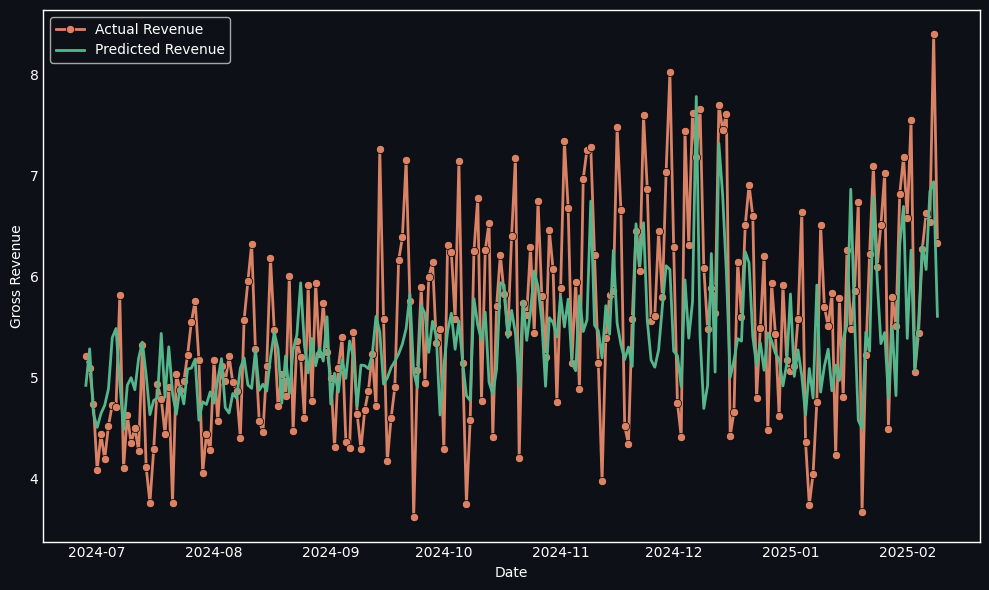

In [176]:
model_evaluator(rf_pipe,rf_param_grid)